Задание 1.

Для реализованной в методичке модели градиентного бустинга построить зависимости ошибки от количества деревьев при разных значениях шага градиента на одном графике и для разной глубины деревьев на другом.
Сделать выводы о зависимости ошибки от этих гиперпараметров (шаг градиента, максимальная глубина деревьев, количество деревьев).
Подобрать оптимальные значения этих гиперпараметров (минимум ошибки на тесте при отсутствии переобучения).

In [1]:
from sklearn.tree import DecisionTreeRegressor
from sklearn import model_selection
import numpy as np

In [2]:
from sklearn.datasets import load_diabetes

In [3]:
X, y = load_diabetes(return_X_y=True)
X.shape, y.shape

((442, 10), (442,))

In [4]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25, random_state=42)

In [5]:
def gb_predict(X, trees_list, coef_list, eta):
    # Реализуемый алгоритм градиентного бустинга будет инициализироваться нулевыми значениями,
    # поэтому все деревья из списка trees_list уже являются дополнительными и при предсказании 
    # прибавляются с шагом eta
    return np.array([sum([
        eta * coef * alg.predict([x])[0] for alg, coef in zip(trees_list, coef_list)]) 
                     for x in X])

In [6]:
def mean_squared_error(y_real, prediction):
    return (sum((y_real - prediction) ** 2)) / len(y_real)

In [7]:
def bias(y, z):
    return - 2 * (z - y)

In [17]:
def gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta):
    
    # eta - скорость обучения
    # Деревья будем записывать в список
    trees = []
    
    # Будем записывать ошибки на обучающей и тестовой выборке на каждой итерации в список
    train_errors = []
    test_errors = []
    
    for i in range(n_trees):
        tree = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
        coefs = [1] * n_trees

        # инициализируем бустинг начальным алгоритмом, возвращающим ноль, 
        # поэтому первый алгоритм просто обучаем на выборке и добавляем в список
        if len(trees) == 0:
            # обучаем первое дерево на обучающей выборке
            tree.fit(X_train, y_train)
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))
        else:
            # Получим ответы на текущей композиции
            z_train = gb_predict(X_train, trees, coefs, eta)
            
            # алгоритмы, начиная со второго, обучаем на сдвиг
            tree.fit(X_train, bias(y_train, z_train))
            
            train_errors.append(mean_squared_error(y_train, gb_predict(X_train, trees, coefs, eta)))
            test_errors.append(mean_squared_error(y_test, gb_predict(X_test, trees, coefs, eta)))

        trees.append(tree)
        
    return trees, train_errors, test_errors

Построим графики зависимости от параметра eta для значений eta 0.01, 0.1 и 1.0

In [43]:
max_depth = 3
train_matrix = []
test_matrix = []
eta_range = [0.01, 0.1, 1.0]
n_trees = 20
for eta in eta_range:
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    train_matrix.append(train_errors)
    test_matrix.append(test_errors)

In [44]:
import matplotlib.pyplot as plt

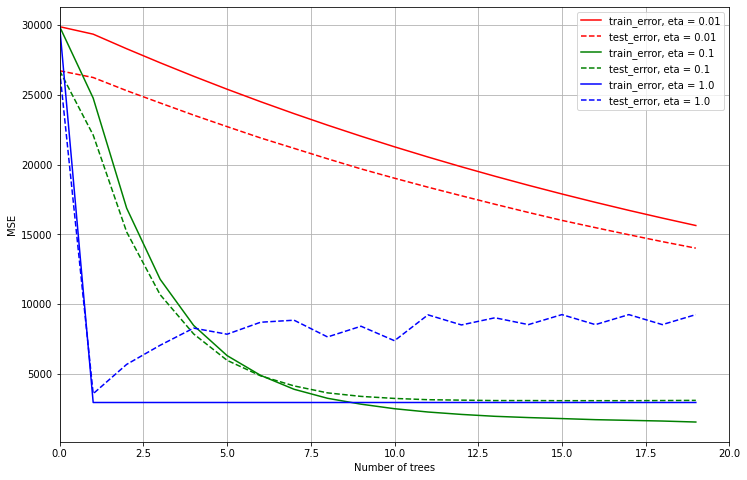

In [45]:
plt.figure(figsize = (12, 8));
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
for i, (eta, color) in enumerate(zip(eta_range, ['red', 'green', 'blue'])):
    plt.plot(list(range(n_trees)), train_matrix[i], color = color, label=f'train_error, eta = {eta}')
    plt.plot(list(range(n_trees)), test_matrix[i], color = color, linestyle = 'dashed', label=f'test_error, eta = {eta}')
plt.legend(loc='upper right')
plt.grid()
plt.show()

Если судить по графику, из трех параметров eta наилучшим является 0.1, так как он не требует слишком большого количества деревьев в ансамбле (обучение проходит достаточно быстро), и в дополнение к этому не приводит к переобучению - с ростом количества деревьев нет скачка test loss в сравнении с более быстро обучающимся eta = 1.0


Построим аналогичные зависимости от глубины деревьев

In [46]:
depth_range = [2, 6, 12]
train_matrix = []
test_matrix = []
n_trees = 20
eta = 0.1
for max_depth in depth_range:
    trees, train_errors, test_errors = gb_fit(n_trees, max_depth, X_train, X_test, y_train, y_test, eta)
    train_matrix.append(train_errors)
    test_matrix.append(test_errors)

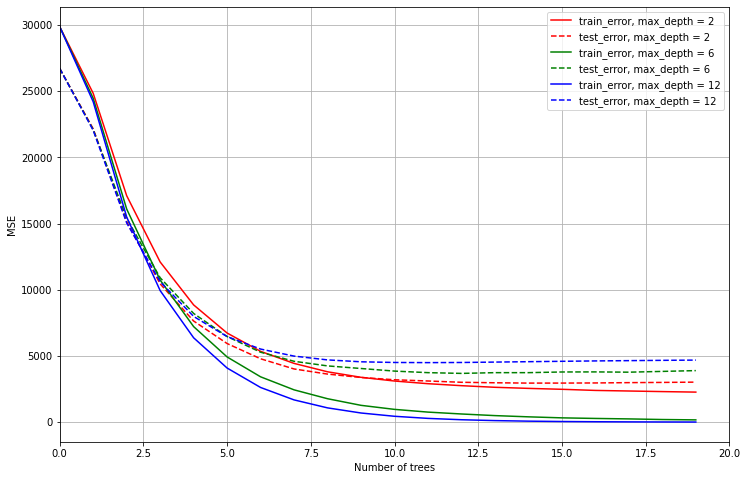

In [47]:
plt.figure(figsize = (12, 8));
plt.xlabel('Number of trees')
plt.ylabel('MSE')
plt.xlim(0, n_trees)
for i, (max_depth, color) in enumerate(zip(depth_range, ['red', 'green', 'blue'])):
    plt.plot(list(range(n_trees)), train_matrix[i], color = color, label=f'train_error, max_depth = {max_depth}')
    plt.plot(list(range(n_trees)), test_matrix[i], color = color, linestyle = 'dashed', label=f'test_error, max_depth = {max_depth}')
plt.legend(loc='upper right')
plt.grid()
plt.show()

В исследовании зависимости train|test error от максимальной глубины деревьев видим несколько иную ситуацию, чем при исследовании eta. Несмотря на шестикратное изменение глубины дерева, драматического различия в ошибках ни на обучающей выборке, ни на тестовой выборке нет. Видно, что на обучающей выборке функции стремятся к нулю, причем как деревья глубины 6, так и деревья глубины 12 дают почти одинаковую скорость обучения. Вместе с тем, ошибка на тестовом датасете для деревьев глубины 12 максимальна, а для деревьев глубины 2 минимальна, несмотря на то, что при идентичном количестве деревьев на тренировочном датасете ансамбль показывает максимальную ошибку. По всей видимости, имеет место переобучение, и наилучшим параметром данном случае будет max_depth = 2.